# Discharge Calculation

## Introduction and Theory

This notebook demonstrates how to calculate river discharge using PIV results and cross-section data. We'll convert pixel displacements to real-world velocities and combine them with bathymetry data to compute volumetric flow rates.

### Key Concepts

1. **Discharge Calculation**:
   - Q = V × A (Velocity × Area)
   - Integration across cross-section
   - Depth-averaged velocity estimation

2. **Velocity Components**:
   - Conversion from pixel to real-world coordinates
   - Consideration of camera frame rate
   - Alpha coefficient for surface-to-depth velocity ratio

3. **Cross-section Elements**:
   - Bathymetry profile
   - Station spacing
   - Water level

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import sys
# Add the notebook directory to Python path
notebook_dir = Path.cwd()
if str(notebook_dir) not in sys.path:
    sys.path.append(str(notebook_dir))

# Import the function to plot arrows
from utils.arrow_utils import calculate_multiple_arrows

# Import RIVeR modules
from river.core.compute_section import update_current_x_section


# Set up paths
frame_dir = Path("data/frames/pisco")
frame_path = Path("data/frames/pisco/0000000004.jpg")
transformation_file = Path("results/pisco/transformation.json")
xsections_file = Path("results/pisco/section.json")
piv_results_file = Path("results/pisco/piv_results.json")
output_dir = Path("results/pisco")

## Step 1: Load Input Data

We begin by loading all necessary data for discharge calculations:
- Transform matrix for coordinate conversion
- Cross-section definitions
- PIV analysis results
- Reference frame for visualization

The transform matrix converts PIV displacements from pixels to real-world coordinates, while cross-section data provides bathymetry and station information needed for area calculations.


In [2]:
# Load transformation matrix
with open(transformation_file, 'r') as f:
    transformation_matrix = np.array(json.load(f))

# Load cross-sections data
with open(xsections_file, 'r') as f:
    xsections = json.load(f)

# Load piv results data
with open(piv_results_file, 'r') as f:
    piv_results = json.load(f)

# Load the image
frame = cv2.imread(str(frame_path))
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

## Step 2: Configure Cross-Section Analysis Parameters

The cross-section analysis requires several key parameters to accurately calculate discharge:

### Essential Parameters:
- **Frame Rate (fps)**: Video capture frequency from video exif(e.g., 30 fps)
- **Frame Step**: Number of frames between PIV pairs from frames extraction (affects time between velocity measurements)
- **Alpha Coefficient**: Ratio between surface and depth-averaged velocity (typically 0.85-1.0)
- **Number of Stations**: Points for numerical integration across the section
- **Interpolation**: Whether to fill data gaps using interpolation

### Optional Parameters:
- **Artificial Seeding**: Whether the tracer used was artificialy seeded
- **Multipass**: Use multiple PIV passes for improved accuracy
- **Standard Filter**: Apply standard deviation filtering to velocity measurements
- **Median Test Filter**: Remove outliers using median comparison

### Function: update_current_x_section

This function performs three main tasks:
1. Updates velocity profiles for the cross-section
2. Calculates discharge using the configured parameters
3. Returns statistical summaries including:
   - Total discharge (Q)
   - Average velocity
   - Cross-sectional area
   - Depth

In [3]:
fps = 25
step = 2

alpha = xsections['section1']['alpha']
num_stations = xsections['section1']['num_stations']
summary = update_current_x_section(xsections,
                                   piv_results,
                                   transformation_matrix,
                                   step,
                                   fps,
                                   0,
                                   alpha = alpha,
                                   num_stations= num_stations,
                                   interpolate=True)

## Step 3: Visualize Cross-section Analysis Results

The analysis results are presented in a comprehensive four-panel visualization that combines spatial and quantitative data:

### Left Panel: Spatial Visualization
- Frame from the video showing the cross-section location
- Color-coded endpoints (red: left bank, green: right bank)
- Velocity vectors scaled and colored by magnitude

### Right Panels: Quantitative Analysis

1. **Discharge Distribution** (Top)
   - Bar plot showing proportion of total discharge along the cross-section
   - Color-coded bars indicating contribution levels:
     - Red: High contribution (>10% of total)
     - Yellow: Medium contribution (5-10%)
     - Green: Low contribution (<5%)

2. **Velocity Profile** (Middle)
   - Green shaded area: ±1 standard deviation
   - Red shaded area: 5th to 95th percentile range

3. **Depth Profile** (Bottom)
   - Shows channel morphology along cross-section

The visualization integrates spatial context with quantitative measurements, allowing for comprehensive interpretation of the flow characteristics at the cross-section.

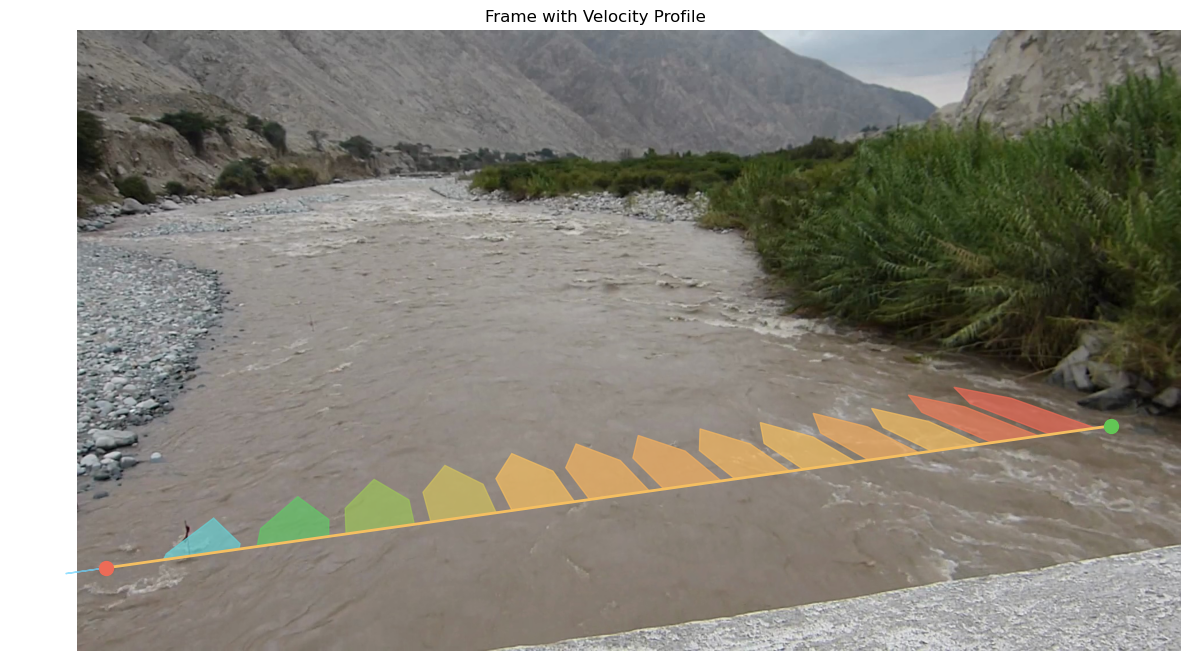

In [4]:
# Visualize mask overlaid on the frame
plt.figure(figsize=(12, 8))

# Display the original frame first
plt.imshow(frame_rgb)
# Add the Cross Section
plt.plot([xsections["section1"]["xl"], xsections["section1"]["xr"]], 
         [xsections["section1"]["yl"], xsections["section1"]["yr"]], 
         color='#F5BF61', linewidth=2)  # Line connecting points
plt.plot(xsections["section1"]["xl"], xsections["section1"]["yl"], 'o', color='#ED6B57', markersize=10)  # Left point
plt.plot(xsections["section1"]["xr"], xsections["section1"]["yr"], 'o', color='#62C655', markersize=10)  # Right point

width_arrow = 0.8* np.mean(np.diff(summary['section1']['distance']))
arrows, magnitude_range = calculate_multiple_arrows(
    summary['section1']['east'],
    summary['section1']['north'],
    summary['section1']['filled_streamwise_velocity_magnitude'],
    transformation_matrix,
    frame_rgb.shape[0],
    width=width_arrow
)

# Plot each arrow
for arrow in arrows:
    plt.fill(arrow['points'][:, 0], arrow['points'][:, 1], color=arrow['color'],alpha=0.7)

plt.title('Frame with Velocity Profile')
plt.axis('off')
plt.tight_layout()
plt.show()





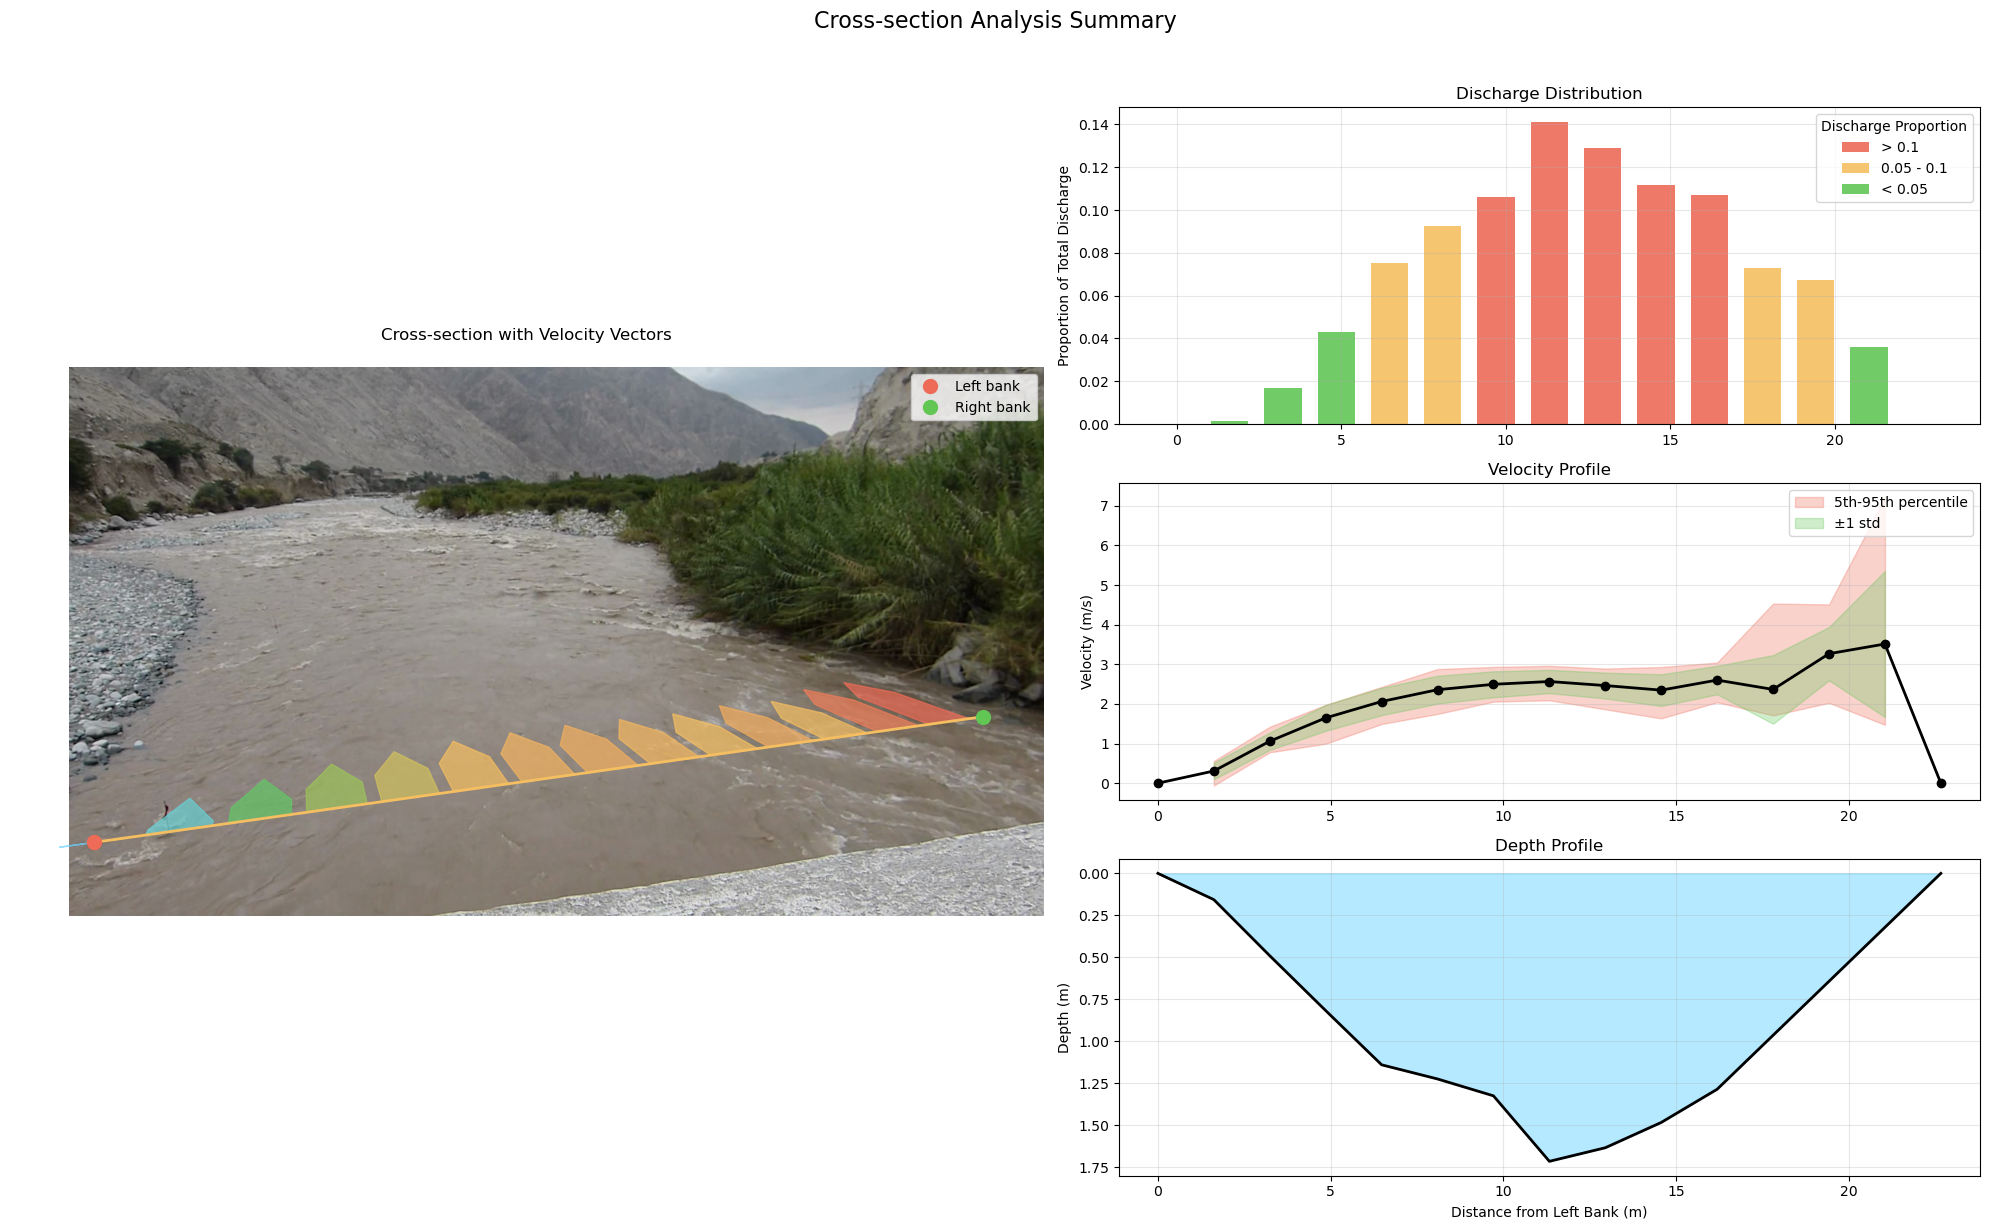

Total Discharge: 50.52 ± 9.09 m³/s
Mean Velocity: 2.36 m/s
Total Width: 21.15 m
Maximum Depth: 1.76 m


In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Create figure with custom grid layout
fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(3, 2, width_ratios=[1.2, 1], height_ratios=[1, 1, 1])

# Left column: Frame with velocity arrows
ax0 = plt.subplot(gs[:, 0])  # Spans all rows in first column
ax0.imshow(frame_rgb)

# Plot cross-section line
ax0.plot([xsections["section1"]["xl"], xsections["section1"]["xr"]], 
         [xsections["section1"]["yl"], xsections["section1"]["yr"]], 
         color='#F5BF61', linewidth=2)

# Plot end points
ax0.plot(xsections["section1"]["xl"], xsections["section1"]["yl"], 
         'o', color='#ED6B57', markersize=10, label='Left bank')
ax0.plot(xsections["section1"]["xr"], xsections["section1"]["yr"], 
         'o', color='#62C655', markersize=10, label='Right bank')

# Calculate and plot velocity arrows
width_arrow = 0.8 * np.mean(np.diff(summary['section1']['distance']))
arrows, magnitude_range = calculate_multiple_arrows(
    summary['section1']['east'],
    summary['section1']['north'],
    summary['section1']['filled_streamwise_velocity_magnitude'],
    transformation_matrix,
    frame_rgb.shape[0],
    width=width_arrow
)

# Plot arrows
for arrow in arrows:
    ax0.fill(arrow['points'][:, 0], arrow['points'][:, 1], 
             color=arrow['color'], alpha=0.7)
ax0.set_title('Cross-section with Velocity Vectors', pad=20)
ax0.axis('off')
ax0.legend()

# Right column plots
# 1. Discharge Distribution (as bars with colors based on values)
ax1 = plt.subplot(gs[0, 1])
bar_width = 0.7 * np.mean(np.diff(summary['section1']['distance']))

# Create color array based on values
colors = []
for q in summary['section1']['Q_portion']:
    if q > 0.1:
        colors.append('#ED6B57')
    elif q > 0.05:
        colors.append('#F5BF61')
    else:
        colors.append('#62C655')

ax1.bar(summary['section1']['distance'], 
        summary['section1']['Q_portion'],
        width=bar_width,
        color=colors,
        alpha=0.9,
        align='center')
ax1.set_title('Discharge Distribution')
ax1.set_ylabel('Proportion of Total Discharge')
ax1.grid(True, alpha=0.3)

# Add legend for discharge colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#ED6B57', alpha=0.9, label='> 0.1'),
    Patch(facecolor='#F5BF61', alpha=0.9, label='0.05 - 0.1'),
    Patch(facecolor='#62C655', alpha=0.9, label='< 0.05')
]
ax1.legend(handles=legend_elements, title='Discharge Proportion')

# 2. Velocity Profile - black line with points
ax2 = plt.subplot(gs[1, 1])
# Add 5th and 95th percentile area
ax2.fill_between(summary['section1']['distance'],
                 summary['section1']['5th_percentile'],
                 summary['section1']['95th_percentile'],
                 color='#ED6B57', alpha=0.3, label='5th-95th percentile')
# Add standard deviation area
ax2.fill_between(summary['section1']['distance'],
                 summary['section1']['minus_std'],
                 summary['section1']['plus_std'],
                 color='#62C655', alpha=0.3, label='±1 std')
ax2.plot(summary['section1']['distance'], 
         summary['section1']['filled_streamwise_velocity_magnitude'],
         'k-', linewidth=2)  # black line
ax2.plot(summary['section1']['distance'], 
         summary['section1']['filled_streamwise_velocity_magnitude'],
         'ko', markersize=6)  # black points
ax2.set_title('Velocity Profile')
ax2.set_ylabel('Velocity (m/s)')
ax2.grid(True, alpha=0.3)
ax2.legend()

# 3. Depth Profile - black line with light blue fill
ax3 = plt.subplot(gs[2, 1])
ax3.plot(summary['section1']['distance'], 
         summary['section1']['depth'],
         'k-', linewidth=2)  # black line
ax3.fill_between(summary['section1']['distance'],
                 summary['section1']['depth'],
                 color='#6CD4FF', alpha=0.5)  # light blue fill
ax3.set_title('Depth Profile')
ax3.set_xlabel('Distance from Left Bank (m)')
ax3.set_ylabel('Depth (m)')
ax3.grid(True, alpha=0.3)
ax3.invert_yaxis()  # Invert y-axis to show depth properly

# Add overall title and adjust layout
plt.suptitle('Cross-section Analysis Summary', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Print numerical summary
print(f"Total Discharge: {summary['section1']['total_Q']:.2f} ± {summary['section1']['total_q_std']:.2f} m³/s")
print(f"Mean Velocity: {summary['section1']['mean_V']:.2f} m/s")
print(f"Total Width: {summary['section1']['total_W']:.2f} m")
print(f"Maximum Depth: {summary['section1']['max_depth']:.2f} m")